# Model Optimization 

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
sns.set(style="darkgrid", context="notebook")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from tensorflow.keras import layers

from zipfile import ZipFile

import warnings
warnings.filterwarnings("ignore")

print(tf.version.VERSION)
print(keras.__version__)

2.7.0
2.7.0


Temporary daily basis, and live digital campaigns data sets were utilized for this part of study. Other auxilary data sets were not seems to valid due to their time range.   

In [4]:
time_data = pd.read_csv("time_data.csv",
                        index_col="date")
live_digit = pd.read_csv("live_digital_campaigns.csv",
                         index_col="date")

In [5]:
time_df = time_data.copy()
live_df = live_digit.copy()
live_df.drop(live_df.index[-1], inplace=True)
time_df = time_df.merge(live_df, how="left", on="date")

- We designed optimization experiments heuristically. It was not seemed to feasible to implement an permutation based feature selection. So, we employed a forward approach to select best features. Features were ordered as their daily numbers included, and their importance heuristically.

- Number of time steps were included the experiments as a list of candidate numbers to find their optimal values. 

In [24]:
def series_to_supervised(data, n_in=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [("var%d(t-%d)" % (j+1, i)) for j in range(n_vars)]
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [24]:
feat = ["daily_sum",
        "Google Ads",
        "Product D",
        "Product A",
        "Organic search",
        "Facebook",
        "CRM",
        "Product B",
        "Product E",
        "Direct",
        "Product C",
        "Product F",
        "Referral",
        "live_campaign"]

track_df = pd.DataFrame(columns=["mse", "feat", "step"])
for t in [35, 30, 25, 20]:
    track = list()
    for f in feat:
        track.append(f)
        df = time_df[track]

        time_step = t
        n_train = 320

        sc_X = MinMaxScaler(feature_range=(0,1))
        sc_y = MinMaxScaler(feature_range=(0,1))

        reframed = series_to_supervised(df, time_step)
        reframed = reframed.merge(df["daily_sum"], how="left", on="date")

        X_scaled = sc_X.fit_transform(reframed.drop(columns="daily_sum"))
        y_scaled = sc_y.fit_transform(reframed["daily_sum"].values.reshape(-1, 1))

        X_train, X_test = X_scaled[:n_train, :], X_scaled[n_train:, :]
        y_train, y_test = y_scaled[:n_train, :], y_scaled[n_train:, :]

        X_train = np.reshape(X_train, (X_train.shape[0], time_step, df.shape[1]))
        X_test = np.reshape(X_test, (X_test.shape[0], time_step, df.shape[1]))

        input_lead = layers.Input(shape=(time_step, X_train.shape[2]),
                                  name="input_lead")
        b = layers.Bidirectional(layers.LSTM(units=200,
                                             return_sequences=True))(input_lead)
        b = layers.Bidirectional(layers.LSTM(units=150))(b)
        d = layers.Dense(20, activation="tanh")(b)
        d = layers.Dropout(0.2)(d)
        output = layers.Dense(1, name="output")(d)
        model_2 = keras.Model(input_lead, output)
        model_2.compile(loss="mean_squared_error",
                        optimizer=keras.optimizers.Adam(learning_rate=0.0001))
        
        es = keras.callbacks.EarlyStopping(monitor="loss",
                                        mode="min",
                                        verbose=1,
                                        patience=5)
        model_2.fit(X_train, y_train,
                    epochs=30,
                    batch_size=16,
                    callbacks=[es],
                    verbose=0)

        y_pred = model_2.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        newtrack = pd.Series({"mse":mse, "feat": ",".join(track), "step":t})
        track_df = track_df.append(newtrack, ignore_index=True)

Epoch 00016: early stopping
Epoch 00030: early stopping
Epoch 00019: early stopping
Epoch 00010: early stopping
Epoch 00012: early stopping
Epoch 00010: early stopping
Epoch 00019: early stopping
Epoch 00019: early stopping
Epoch 00011: early stopping
Epoch 00027: early stopping
Epoch 00016: early stopping
Epoch 00011: early stopping
Epoch 00023: early stopping
Epoch 00020: early stopping
Epoch 00011: early stopping
Epoch 00017: early stopping
Epoch 00014: early stopping
Epoch 00017: early stopping
Epoch 00009: early stopping
Epoch 00019: early stopping
Epoch 00020: early stopping
Epoch 00022: early stopping
Epoch 00014: early stopping
Epoch 00011: early stopping
Epoch 00018: early stopping
Epoch 00028: early stopping
Epoch 00016: early stopping
Epoch 00013: early stopping
Epoch 00014: early stopping
Epoch 00025: early stopping
Epoch 00014: early stopping
Epoch 00026: early stopping
Epoch 00025: early stopping
Epoch 00013: early stopping
Epoch 00018: early stopping
Epoch 00027: early s

In [26]:
track_df.to_csv("track_file.csv", index=False)

# Best Configuration

According to experiment results

In [6]:
track_df = pd.read_csv("track_file.csv")

In [13]:
track_df.sort_values("mse").head(5)

,mse,feat,time_step,step
25,0.017892,"daily_sum,Google Ads,Product D,Product A,Organ...",NaN,30.0
21,0.017945,"daily_sum,Google Ads,Product D,Product A,Organ...",NaN,30.0
47,0.017988,"daily_sum,Google Ads,Product D,Product A,Organ...",NaN,20.0
22,0.018128,"daily_sum,Google Ads,Product D,Product A,Organ...",NaN,30.0
27,0.018423,"daily_sum,Google Ads,Product D,Product A,Organ...",NaN,30.0


In [20]:
best_feat = track_df.sort_values("mse").head(1)["feat"].values[0].split(",")
df = time_df[best_feat]

In [28]:
time_step = 30
n_train = 320

sc_X = MinMaxScaler(feature_range=(0,1))
sc_y = MinMaxScaler(feature_range=(0,1))

reframed = series_to_supervised(df, time_step)
reframed = reframed.merge(df["daily_sum"], how="left", on="date")

X_scaled = sc_X.fit_transform(reframed.drop(columns="daily_sum"))
y_scaled = sc_y.fit_transform(reframed["daily_sum"].values.reshape(-1, 1))

X_train, X_test = X_scaled[:n_train, :], X_scaled[n_train:, :]
y_train, y_test = y_scaled[:n_train, :], y_scaled[n_train:, :]

X_train = np.reshape(X_train, (X_train.shape[0], time_step, df.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], time_step, df.shape[1]))

In [29]:
input_lead = layers.Input(shape=(time_step, X_train.shape[2]),
                    name="input_lead")
b = layers.Bidirectional(layers.LSTM(units=200,
                                    return_sequences=True))(input_lead)
b = layers.Bidirectional(layers.LSTM(units=150))(b)
d = layers.Dense(20, activation="tanh")(b)
d = layers.Dropout(0.2)(d)
output = layers.Dense(1, name="output")(d)
model_2 = keras.Model(input_lead, output)
model_2.compile(loss="mean_squared_error",
                optimizer=keras.optimizers.Adam(learning_rate=0.0001))
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_lead (InputLayer)     [(None, 30, 12)]          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 30, 400)          340800    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 300)              661200    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 20)                6020      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 output (Dense)              (None, 1)                 21  

In [30]:
es = keras.callbacks.EarlyStopping(monitor="loss",
                                        mode="min",
                                        verbose=1,
                                        patience=5)
model_2.fit(X_train, y_train,
            epochs=30,
            batch_size=16,
            callbacks=[es],
            verbose=1)

Epoch 1/30
20/20 [==============================] - 7s 51ms/step - loss: 0.0586
Epoch 2/30
20/20 [==============================] - 1s 50ms/step - loss: 0.0312
Epoch 3/30
20/20 [==============================] - 1s 50ms/step - loss: 0.0284
Epoch 4/30
20/20 [==============================] - 1s 51ms/step - loss: 0.0258
Epoch 5/30
20/20 [==============================] - 1s 52ms/step - loss: 0.0264
Epoch 6/30
20/20 [==============================] - 1s 50ms/step - loss: 0.0278
Epoch 7/30
20/20 [==============================] - 1s 50ms/step - loss: 0.0271
Epoch 8/30
20/20 [==============================] - 1s 51ms/step - loss: 0.0244
Epoch 9/30
20/20 [==============================] - 1s 49ms/step - loss: 0.0265
Epoch 10/30
20/20 [==============================] - 1s 50ms/step - loss: 0.0247
Epoch 11/30
20/20 [==============================] - 1s 50ms/step - loss: 0.0253
Epoch 12/30
20/20 [==============================] - 1s 50ms/step - loss: 0.0246
Epoch 13/30
20/20 [==================

In [35]:
y_pred = model_2.predict(X_test)
mean_squared_error(y_test, y_pred)

0.01852156831338802

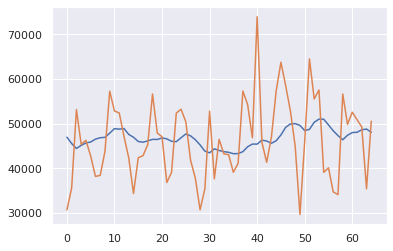

In [36]:
y_pred_ = sc_y.inverse_transform(y_pred)
y_test_ = sc_y.inverse_transform(y_test)

plt.plot(y_pred_)
plt.plot(y_test_)
plt.show()